In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import missingno as msno
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

#sns.set()

%matplotlib inline

1. initialize data
- drop MAR,MCAR missing value
- fill MNAR missing value
- type convert(date,price,etc)
- drop outliers
2. feature engineering
- multicollinearity
- one hot encode
3. quick random forest: see the important features
4. tune paremeters

# Initialize Data

In [ ]:
dfs = {}  # Dictionary to store DataFrames

# Loop through numbers 1 to 11 for the first set of files
for i in range(3, 12):
    df_key = f'df2023_{i}'  # Create a unique key for each DataFrame
    df = pd.read_csv(f'df2023_{i}.csv')
    dfs[df_key] = df


# Loop through numbers 1 to 2 for the second set of files
for i in range(1, 3):
    df_key = f'df2024_{i}'  # Create a unique key for each DataFrame
    df = pd.read_csv(f'df2024_{i}.csv')
    dfs[df_key] = df

## Pick important columns:

In [ ]:
# pick important columns:
for i in range(3, 12):
  dfs['df2023_' + str(i)].drop(['listing_url', 'scrape_id','source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name','host_location', 'host_about','host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications', 'neighbourhood','latitude','neighbourhood_group_cleansed','calendar_last_scraped',
       'longitude','license','neighbourhood_cleansed','bathrooms_text'],axis=1,inplace=True)

for i in range(1, 3):
  dfs['df2024_' + str(i)].drop(['listing_url', 'scrape_id','source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name','host_location', 'host_about','host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications', 'neighbourhood','latitude','neighbourhood_group_cleansed','calendar_last_scraped',
       'longitude','license','neighbourhood_cleansed','bathrooms_text'],axis=1,inplace=True)

## Transform the format

In [ ]:
# fill missing values
# review columns

# 将字符串转换为Datetime
for i in range(3, 12):
  dfs['df2023_' + str(i)]['last_scraped'] = pd.to_datetime(dfs['df2023_' + str(i)]['last_scraped'])
  for col in ['host_since', 'first_review', 'last_review']:
      # Ensure that the column is in datetime format
      dfs['df2023_' + str(i)][col] = pd.to_datetime(dfs['df2023_' + str(i)][col], errors='coerce')  # Use 'coerce' to handle any parsing errors


  # 对于日期列，选择一个填充值，并转换为天数
  date_fill_value = dfs['df2023_' + str(i)]['first_review'].min(skipna=True)
  dfs['df2023_' + str(i)]['first_review'].fillna(date_fill_value, inplace=True)
  dfs['df2023_' + str(i)]['last_review'].fillna(date_fill_value, inplace=True)

  # 转换日期列为天数
  dfs['df2023_' + str(i)]['days_since_first_review'] = (dfs['df2023_' + str(i)]['last_scraped'] - pd.to_datetime(dfs['df2023_' + str(i)]['first_review'])).dt.days
  dfs['df2023_' + str(i)]['days_since_last_review'] = (dfs['df2023_' + str(i)]['last_scraped'] - pd.to_datetime(dfs['df2023_' + str(i)]['last_review'])).dt.days
  dfs['df2023_' + str(i)]['days_since_host_since'] = (dfs['df2023_' + str(i)]['last_scraped'] - pd.to_datetime(dfs['df2023_' + str(i)]['host_since'])).dt.days
  dfs['df2023_' + str(i)]['days_since_first_review'] = dfs['df2023_' + str(i)]['days_since_first_review'].astype(float)
  dfs['df2023_' + str(i)]['days_since_last_review'] = dfs['df2023_' + str(i)]['days_since_last_review'].astype(float)
  dfs['df2023_' + str(i)]['days_since_host_since'] = dfs['df2023_' + str(i)]['days_since_host_since'].astype(float)

  # 对于评分类列，使用中性值填充缺失值
  for score_col in ['review_scores_rating', 'review_scores_accuracy',
                    'review_scores_cleanliness', 'review_scores_checkin',
                    'review_scores_communication', 'review_scores_location',
                    'review_scores_value']:
      neutral_value = 2.5
      dfs['df2023_' + str(i)][score_col].fillna(neutral_value, inplace=True)

  dfs['df2023_' + str(i)].drop(['last_scraped','first_review', 'last_review','host_since'],axis=1,inplace=True)
  # host_since缺失值已经在前面被删掉

In [ ]:
# fill missing values
# review columns

# 将字符串转换为Datetime
for i in range(1, 3):
  dfs['df2024_' + str(i)]['last_scraped'] = pd.to_datetime(dfs['df2024_' + str(i)]['last_scraped'])
  for col in ['host_since', 'first_review', 'last_review']:
      # Ensure that the column is in datetime format
      dfs['df2024_' + str(i)][col] = pd.to_datetime(dfs['df2024_' + str(i)][col], errors='coerce')  # Use 'coerce' to handle any parsing errors


  # 对于日期列，选择一个填充值，并转换为天数
  date_fill_value = dfs['df2024_' + str(i)]['first_review'].min(skipna=True)
  dfs['df2024_' + str(i)]['first_review'].fillna(date_fill_value, inplace=True)
  dfs['df2024_' + str(i)]['last_review'].fillna(date_fill_value, inplace=True)

  # 转换日期列为天数
  dfs['df2024_' + str(i)]['days_since_first_review'] = (dfs['df2024_' + str(i)]['last_scraped'] - pd.to_datetime(dfs['df2024_' + str(i)]['first_review'])).dt.days
  dfs['df2024_' + str(i)]['days_since_last_review'] = (dfs['df2024_' + str(i)]['last_scraped'] - pd.to_datetime(dfs['df2024_' + str(i)]['last_review'])).dt.days
  dfs['df2024_' + str(i)]['days_since_host_since'] = (dfs['df2024_' + str(i)]['last_scraped'] - pd.to_datetime(dfs['df2024_' + str(i)]['host_since'])).dt.days
  dfs['df2024_' + str(i)]['days_since_first_review'] = dfs['df2024_' + str(i)]['days_since_first_review'].astype(float)
  dfs['df2024_' + str(i)]['days_since_last_review'] = dfs['df2024_' + str(i)]['days_since_last_review'].astype(float)
  dfs['df2024_' + str(i)]['days_since_host_since'] = dfs['df2024_' + str(i)]['days_since_host_since'].astype(float)

  # 对于评分类列，使用中性值填充缺失值
  for score_col in ['review_scores_rating', 'review_scores_accuracy',
                    'review_scores_cleanliness', 'review_scores_checkin',
                    'review_scores_communication', 'review_scores_location',
                    'review_scores_value']:
      neutral_value = 2.5
      dfs['df2024_' + str(i)][score_col].fillna(neutral_value, inplace=True)

  dfs['df2024_' + str(i)].drop(['last_scraped','first_review', 'last_review','host_since'],axis=1,inplace=True)
  # host_since缺失值已经在前面被删掉

In [ ]:
# string to float
columns_to_convert = [
    'host_is_superhost',
    'host_has_profile_pic',
    'host_identity_verified',
    'has_availability',
    'instant_bookable'
]


bool_mapping = {'t': True, 'f': False}

for i in range(3, 12):
    if isinstance(dfs['df2023_' + str(i)]['host_acceptance_rate'].iloc[0], str):
        dfs['df2023_' + str(i)]['host_acceptance_rate'] = dfs['df2023_' + str(i)]['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
    if isinstance(dfs['df2023_' + str(i)]['host_response_rate'].iloc[0], str):
        dfs['df2023_' + str(i)]['host_response_rate'] = dfs['df2023_' + str(i)]['host_response_rate'].str.rstrip('%').astype('float') / 100.0

for col in columns_to_convert:
  for i in range(3, 12):
    # Fill NaN values with 'NAN'
    dfs['df2023_' + str(i)][col] = dfs['df2023_' + str(i)][col].fillna('NAN')
    # Map the 't'/'f' values to True/False
    dfs['df2023_' + str(i)][col] = dfs['df2023_' + str(i)][col].map(bool_mapping)

    #Convert specific columns to numeric
    dfs['df2023_' + str(i)]['host_response_time'] = pd.to_numeric(dfs['df2023_' + str(i)]['host_response_time'], errors='coerce')
    dfs['df2023_' + str(i)]['price'] = pd.to_numeric(dfs['df2023_' + str(i)]['price'], errors='coerce')
    dfs['df2023_' + str(i)]['room_type'] = dfs['df2023_' + str(i)]['room_type'].astype(str)
    dfs['df2023_' + str(i)]['property_type'] = dfs['df2023_' + str(i)]['property_type'].astype(str)


for i in range(1, 3):
    if isinstance(dfs['df2024_' + str(i)]['host_acceptance_rate'].iloc[0], str):
        dfs['df2024_' + str(i)]['host_acceptance_rate'] = dfs['df2024_' + str(i)]['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
    if isinstance(dfs['df2024_' + str(i)]['host_response_rate'].iloc[0], str):
        dfs['df2024_' + str(i)]['host_response_rate'] = dfs['df2024_' + str(i)]['host_response_rate'].str.rstrip('%').astype('float') / 100.0

for col in columns_to_convert:
  for i in range(1, 3):
    # Fill NaN values with 'NAN'
    dfs['df2024_' + str(i)][col] = dfs['df2024_' + str(i)][col].fillna('NAN')
    # Map the 't'/'f' values to True/False
    dfs['df2024_' + str(i)][col] = dfs['df2024_' + str(i)][col].map(bool_mapping)
    dfs['df2024_' + str(i)]['price'] = dfs['df2024_' + str(i)]['price'].replace('[\$,]', '', regex=True).astype(float)

    # Convert specific columns to numeric
    dfs['df2024_' + str(i)]['host_response_time'] = pd.to_numeric(dfs['df2024_' + str(i)]['host_response_time'], errors='coerce')
    dfs['df2024_' + str(i)]['host_is_superhost'] = pd.to_numeric(dfs['df2024_' + str(i)]['host_is_superhost'], errors='coerce')
    dfs['df2024_' + str(i)]['price'] = pd.to_numeric(dfs['df2024_' + str(i)]['price'], errors='coerce')
    dfs['df2024_' + str(i)]['room_type'] = dfs['df2024_' + str(i)]['room_type'].astype(str)
    dfs['df2024_' + str(i)]['property_type'] = dfs['df2024_' + str(i)]['property_type'].astype(str)

## Connect these forms

In [ ]:
dfs_to_concat = []

# Loop through df2023 and df2024
for i in range(3, 12):
    for n in range(1, 3):
        dfs_to_concat.append(dfs['df2023_' + str(i)])
        dfs_to_concat.append(dfs['df2024_' + str(n)])

# Concatenate DataFrames vertically, column-wise
concatenated_df = pd.concat(dfs_to_concat, ignore_index=True)
concatenated_df.head(2)

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,property_type,room_type,accommodates,...,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,days_since_first_review,days_since_last_review,days_since_host_since
0,765948794133787266,NaN,1.0,1.0,False,True,True,Private room in rental unit,Private room,1,...,4.94,True,2,1,1,0,4.46,120.0,17.0,134.0
1,13060365,NaN,NaN,NaN,False,True,True,Private room in rental unit,Private room,1,...,2.50,False,1,0,1,0,0.01,2461.0,2461.0,3690.0


In [ ]:
for column in concatenated_df.columns:
    print(f"'{column}' {concatenated_df[column].dtype}")

'id' int64
'host_response_time' float64
'host_response_rate' object
'host_acceptance_rate' object
'host_is_superhost' object
'host_has_profile_pic' object
'host_identity_verified' object
'property_type' object
'room_type' object
'accommodates' int64
'bathrooms' float64
'bedrooms' float64
'beds' float64
'amenities' object
'price' float64
'minimum_nights' int64
'maximum_nights' int64
'minimum_minimum_nights' float64
'maximum_minimum_nights' float64
'minimum_maximum_nights' float64
'maximum_maximum_nights' float64
'minimum_nights_avg_ntm' float64
'maximum_nights_avg_ntm' float64
'calendar_updated' float64
'has_availability' object
'availability_30' int64
'availability_60' int64
'availability_90' int64
'availability_365' int64
'number_of_reviews' int64
'number_of_reviews_ltm' int64
'number_of_reviews_l30d' int64
'review_scores_rating' float64
'review_scores_accuracy' float64
'review_scores_cleanliness' float64
'review_scores_checkin' float64
'review_scores_communication' float64
'review_sc

In [ ]:
# 筛选出数据类型为 object 的列
object_columns = concatenated_df.select_dtypes(include=['object']).columns

# 遍历每个 object 类型的列，并打印它们的唯一值
for column in object_columns:
    unique_values = concatenated_df[column].unique()
    print(f"Unique values for '{column}': {unique_values}")

Unique values for 'host_response_rate': [1.0 nan 0.91 0.5 0.93 0.62 0.99 0.7 0.83 0.97 0.8 0.94 0.56 0.89 0.96 0.9
 0.6 0.98 0.59 0.81 0.33 0.92 0.17 0.4 0.29 0.82 0.75 0.69 0.78 0.63 0.95
 0.71 0.0 0.14 0.67 0.57 0.68 0.77 0.61 0.86 0.88 0.43 0.84 0.47 0.87 0.25
 0.79 0.2 0.85 0.3 0.11 0.73 0.48 0.74 0.35 0.1 0.22 0.38 0.64 0.19 0.18
 0.42 0.44 0.16 0.76 0.53 0.72 0.46 0.37 0.58 0.13 0.06 0.08 0.36 0.55
 0.66 0.54 0.65 0.27 0.31 0.26 '100%' '0%' '99%' '89%' '50%' '90%' '7%'
 '96%' '80%' '67%' '84%' '70%' '33%' '97%' '81%' '98%' '75%' '88%' '95%'
 '61%' '93%' '65%' '85%' '87%' '40%' '92%' '60%' '83%' '94%' '91%' '25%'
 '30%' '74%' '86%' '82%' '43%' '29%' '77%' '38%' '20%' '76%' '71%' '17%'
 '62%' '78%' '14%' '63%' '10%' '55%' '57%' '73%' '52%' '22%' '68%' '11%'
 '8%' '13%' '69%' '44%' '9%' '56%' '58%' '59%' '19%' '79%' '31%' '42%'
 '36%' '46%' '72%' '34%' '39%' 0.41 0.51 0.39 0.09 0.45 0.28 0.52 0.03
 0.04 0.23 0.32 0.49 0.34 0.21 0.07 0.05 0.15 0.24 0.12 '16%' '15%' '64%'
 '53%' '41%'

In [ ]:
def convert_to_float(value):
    # 如果是字符串形式的百分比值，则去掉百分号并转换为浮点数
    if isinstance(value, str) and value.endswith('%'):
        return float(value.strip('%')) / 100
    # 如果是 NaN 值，则保留为 NaN
    elif pd.isna(value):
        return value
    # 否则，返回原值（已经是浮点数）
    else:
        return float(value)


# 应用转换函数到 'host_response_rate' 列的每个元素
concatenated_df['host_response_rate'] = concatenated_df['host_response_rate'].apply(convert_to_float)
concatenated_df['host_acceptance_rate'] = concatenated_df['host_acceptance_rate'].apply(convert_to_float)


In [ ]:
columns_to_process = ['host_has_profile_pic', 'host_identity_verified', 'has_availability']

for column in columns_to_process:
    # 检查并清理 NaN 值
    concatenated_df[column].fillna('NaN', inplace=True)

    # 将特定值替换为字符串
    concatenated_df[column].replace({False: 'False', True: 'True'}, inplace=True)

    # 确保数据类型的一致性
    concatenated_df[column] = concatenated_df[column].astype(str)

In [ ]:
import ast

In [ ]:
concatenated_df['room_type'] = concatenated_df['room_type'].astype(str)
concatenated_df['amenities_count'] = concatenated_df['amenities'].apply(lambda x: len(ast.literal_eval(x)))
concatenated_df['amenities'] = concatenated_df['amenities_count'].astype(int)

In [ ]:
for column in concatenated_df.columns:
    print(f"'{column}' {concatenated_df[column].dtype}")

'id' int64
'host_response_time' float64
'host_response_rate' float64
'host_acceptance_rate' float64
'host_is_superhost' object
'host_has_profile_pic' object
'host_identity_verified' object
'property_type' object
'room_type' object
'accommodates' int64
'bathrooms' float64
'bedrooms' float64
'beds' float64
'amenities' int64
'price' float64
'minimum_nights' int64
'maximum_nights' int64
'minimum_minimum_nights' float64
'maximum_minimum_nights' float64
'minimum_maximum_nights' float64
'maximum_maximum_nights' float64
'minimum_nights_avg_ntm' float64
'maximum_nights_avg_ntm' float64
'calendar_updated' float64
'has_availability' object
'availability_30' int64
'availability_60' int64
'availability_90' int64
'availability_365' int64
'number_of_reviews' int64
'number_of_reviews_ltm' int64
'number_of_reviews_l30d' int64
'review_scores_rating' float64
'review_scores_accuracy' float64
'review_scores_cleanliness' float64
'review_scores_checkin' float64
'review_scores_communication' float64
'review_s

In [ ]:
num_columns = concatenated_df.shape[1]
print("Number of columns:", num_columns)

Number of columns: 49


In [ ]:
# Drop missing values in concatenated_df for all columns
threshold = 0.7  # 70% threshold for missing values

for col in concatenated_df.columns:
    missing_proportion = concatenated_df[col].isna().mean()  # Proportion of missing values
    if missing_proportion > threshold:
        # Drop the column
        concatenated_df.drop(col, axis=1, inplace=True)
    elif missing_proportion > 0:
        # Drop rows with missing values in this column
        concatenated_df = concatenated_df.dropna(subset=[col])

In [ ]:
num_columns = concatenated_df.shape[1]
print("Number of columns:", num_columns)

Number of columns: 47


In [ ]:
concatenated_df['price'].head()

43241    30.0
43242    30.0
43244    50.0
43246    29.0
43250    42.0
Name: price, dtype: float64

In [ ]:
def mode_func(x):
    # 如果x是空的，返回None
    if x.empty:
        return None
    # 对于数值类型的列，返回出现频率最高的数字
    elif pd.api.types.is_numeric_dtype(x):
        return x.mode().iloc[0]
    # 对于字符串类型的列，返回出现频率最高的词
    elif pd.api.types.is_string_dtype(x):
        return x.mode().iloc[0]
    # 对于其他类型的列，返回None
    else:
        return None


def custom_groupby_rule(x):
    if pd.Series(x).any() == True:
        return 'True'
    elif pd.Series(x).any() == False:
        return 'False'
    else:
        return 'NAN'



aggregated_df = concatenated_df.groupby('id').agg({
    'host_response_rate': 'mean',
    'host_acceptance_rate': 'mean',
    'host_is_superhost': lambda x: x.mode().iloc[0] if not x.empty else None,
    'host_has_profile_pic': lambda x: x.mode().iloc[0] if not x.empty else None,
    'property_type': lambda x: x.mode().iloc[0] if not x.empty else None,
    'room_type': lambda x: x.mode().iloc[0] if not x.empty else None,
    'accommodates': 'mean',
    'bathrooms': 'mean',
    'bedrooms': 'mean',
    'beds': 'mean',
    'price': 'mean',
    'minimum_nights': 'mean',
    'maximum_nights': 'mean',
    'minimum_minimum_nights': 'mean',
    'maximum_minimum_nights': 'mean',
    'minimum_maximum_nights': 'mean',
    'maximum_maximum_nights': 'mean',
    'minimum_nights_avg_ntm': 'mean',
    'maximum_nights_avg_ntm': 'mean',
    'has_availability': lambda x: custom_groupby_rule(x),
    'host_identity_verified': lambda x: x.mode().iloc[0] if not x.empty else None,
    'instant_bookable': lambda x: x.mode().iloc[0] if not x.empty else None,
    'calculated_host_listings_count': 'mean',
    'calculated_host_listings_count_entire_homes': 'mean',
    'calculated_host_listings_count_private_rooms': 'mean',
    'calculated_host_listings_count_shared_rooms': 'mean',
    'reviews_per_month': 'mean',
    'days_since_first_review': 'max',
    'days_since_last_review': 'min',
    'days_since_host_since': 'min',
    'availability_30':'mean',
    'availability_60':'mean',
    'availability_90':'mean',
    'availability_365':'mean',
    'number_of_reviews':'mean',
    'number_of_reviews_ltm':'mean',
    'number_of_reviews_l30d':'mean',
    'review_scores_rating':'mean',
    'review_scores_accuracy':'mean',
    'review_scores_cleanliness':'mean',
    'review_scores_checkin':'mean',
    'review_scores_communication':'mean',
    'review_scores_location':'mean',
    'review_scores_value':'mean',
    'amenities':'mean'

})

In [ ]:
aggregated_df.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,property_type,room_type,accommodates,bathrooms,bedrooms,beds,...,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,amenities
id,,,,,,,,,,,,,,,,,,,,,
2595,0.97,0.255,0.0,True,Entire rental unit,Entire home/apt,1.0,1.0,0.0,1.0,...,0.0,0.0,4.68,4.73,4.63,4.77,4.80,4.81,4.40,32.0
6848,1.00,1.000,1.0,True,Entire rental unit,Entire home/apt,3.0,1.0,2.0,1.0,...,3.0,0.5,4.58,4.59,4.86,4.85,4.80,4.68,4.57,26.0
6872,1.00,0.000,0.0,True,Private room in condo,Private room,1.0,1.0,1.0,1.0,...,0.0,0.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,18.0
6990,1.00,1.000,1.0,True,Private room in rental unit,Private room,1.0,1.0,1.0,1.0,...,3.0,0.0,4.88,4.83,4.96,4.96,4.95,4.85,4.84,19.0
7097,1.00,1.000,1.0,True,Private room in guest suite,Private room,2.0,1.0,1.0,2.0,...,39.0,2.0,4.88,4.90,4.89,4.96,4.93,4.94,4.81,49.0


In [ ]:
aggregated_df.describe()

,host_response_rate,host_acceptance_rate,host_is_superhost,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,...,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,amenities
count,14716.000000,14716.000000,14716.000000,14716.000000,14716.000000,14716.000000,14716.000000,14716.000000,14716.000000,14716.000000,...,14716.000000,14716.000000,14716.000000,14716.000000,14716.000000,14716.000000,14716.000000,14716.000000,14716.000000,14716.000000
mean,0.937638,0.842523,0.422465,3.015663,1.191390,1.306979,1.712932,170.422194,25.028982,502.090174,...,11.940031,0.460111,4.710728,4.737254,4.670143,4.814420,4.793969,4.726467,4.600276,33.550829
std,0.177480,0.228209,0.493969,2.055865,0.502057,0.910466,1.228264,196.729148,19.072656,429.131071,...,24.744739,2.064202,0.462498,0.458831,0.490679,0.395322,0.447236,0.392294,0.514168,14.322586
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,9.000000,1.000000,2.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.980000,0.780000,0.000000,2.000000,1.000000,1.000000,1.000000,80.000000,30.000000,100.000000,...,1.000000,0.000000,4.640000,4.680000,4.570000,4.800000,4.780000,4.630000,4.500000,23.000000
50%,1.000000,0.950000,0.000000,2.000000,1.000000,1.000000,1.000000,125.000000,30.000000,365.000000,...,4.000000,0.000000,4.840000,4.875000,4.810000,4.930000,4.940000,4.820000,4.740000,33.000000
75%,1.000000,1.000000,1.000000,4.000000,1.000000,2.000000,2.000000,199.000000,30.000000,1125.000000,...,17.000000,0.500000,5.000000,5.000000,4.980000,5.000000,5.000000,5.000000,4.890000,44.000000
max,1.000000,1.000000,1.000000,16.000000,11.500000,15.000000,21.000000,7498.000000,999.000000,1125.000000,...,1098.500000,117.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,101.000000


In [ ]:
import geopandas as gpd
from fiona.crs import from_epsg

In [ ]:
# Get the current directory
current_directory = os.getcwd()

# Define the path to the data folder
data_folder = os.path.join(current_directory, '')
transportaion_data_folder = os.path.join(data_folder, '')
geojson_path = os.path.join(transportaion_data_folder, 'transportation_data.json')
feature_description_path = os.path.join(transportaion_data_folder, 'feature_description.txt')

In [ ]:
# # # 读取 JSON 文件
# gdf = gpd.read_file(geojson_path)
# gdf = gdf.read_file(epsg=4326)

# print(gdf.head())

In [ ]:
crs = "EPSG:4326"  # 要转个两分钟，会有一行报错，但不用管

gdf = gpd.read_file(geojson_path, crs=crs)

In [ ]:
# Read GeoJSON file with specified CRS
gdf.columns

Index(['OBJECTID', 'id', 'price', 'GEOID10', 'GEOID20', 'STATEFP', 'COUNTYFP',
       'TRACTCE', 'BLKGRPCE', 'D3A', 'D3AAO', 'D3AMM', 'D3APO', 'D3B', 'D3BAO',
       'D3BMM3', 'D3BMM4', 'D3BPO3', 'D3BPO4', 'D4A', 'D4C', 'D4D', 'D4E',
       'D5AR', 'D5AE', 'D5BR', 'D5DR', 'D5DRI', 'D5DE', 'D5DEI', 'NatWalkInd',
       'logd3aao', 'logd3apo', 'd5dei_1', 'logd4d', 'UPTpercap', 'SLC_score',
       'geometry'],
      dtype='object')

In [ ]:
gdf=gdf.iloc[:,1:].sort_values('id')

In [ ]:
# column description
feature_description=[{
    'Name':'id',
    'type': 'float64',
    'description':'unique id of a house from listing.csv'
},{
    'Name':'price',
    'type': 'float64',
    'description':'price of a house from listing.csv'
}
]
with open(feature_description_path, 'r', encoding='utf-8') as file:
    for line in file:
        line=line.strip()
        feature={
            'Name': line.split()[0].strip(),
            'type': gdf[line.split()[0].strip()].dtype,
            'description': line.split('(')[1].split(',')[1].split(':')[1].strip()
        }
        feature_description.append(feature)
pd.set_option('display.max_colwidth', None)
display(pd.DataFrame(feature_description))

,Name,type,description
0,id,float64,unique id of a house from listing.csv
1,price,float64,price of a house from listing.csv
2,GEOID10,object,Census block group 12-digit FIPS code
3,GEOID20,object,Census block group 12-digit FIPS code
4,STATEFP,object,State FIPS code
5,COUNTYFP,object,County FIPS code
6,TRACTCE,object,Census tract FIPS code in which CBG resides
7,BLKGRPCE,object,Census block group FIPS code in which CBG resides
8,D3A,float64,Total road network density )
9,D3AAO,float64,Network density in terms of facility miles of auto-oriented links per square mile )


In [ ]:
gdf.head(5)

,id,price,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,D3A,D3AAO,...,D5DE,D5DEI,NatWalkInd,logd3aao,logd3apo,d5dei_1,logd4d,UPTpercap,SLC_score,geometry
36597,2595.0,240.000000,360610113001,360610113001,36,061,011300,1,27.573915,5.263093,...,0.000337,0.802213,12.833333,1.834674,0.546128,1,9,226,96.239359,POINT (-73.98559 40.75356)
10950,5121.0,64.363636,360470229002,360470229002,36,047,022900,2,34.045283,0.000000,...,0.000186,0.442804,13.166667,0.000000,2.433724,0,8,226,88.451023,POINT (-73.95512 40.68535)
4709,5136.0,246.666667,360470145004,360470145004,36,047,014500,4,29.735129,0.000000,...,0.000152,0.360791,15.833333,0.000000,2.239124,0,7,226,93.681762,POINT (-73.99454 40.66265)
42888,5178.0,68.000000,360610137003,360610137003,36,061,013700,3,28.287518,7.390324,...,0.000251,0.597490,11.666667,2.127079,0.000000,1,9,226,97.940346,POINT (-73.98317 40.76457)
52314,5203.0,75.000000,360610195001,360610195001,36,061,019500,1,63.879664,9.339012,...,0.000179,0.426131,18.833333,2.335924,3.534014,0,7,226,93.317625,POINT (-73.96751 40.80380)


In [ ]:
# column description
feature_description=[{
    'Name':'id',
    'type': 'float64',
    'description':'unique id of a house from listing.csv'
},{
    'Name':'price',
    'type': 'float64',
    'description':'price of a house from listing.csv'
}
]
with open(feature_description_path, 'r', encoding='utf-8') as file:
    for line in file:
        line=line.strip()
        feature={
            'Name': line.split()[0].strip(),
            'type': gdf[line.split()[0].strip()].dtype,
            'description': line.split('(')[1].split(',')[1].split(':')[1].strip()
        }
        feature_description.append(feature)
pd.set_option('display.max_colwidth', None)
display(pd.DataFrame(feature_description))

,Name,type,description
0,id,float64,unique id of a house from listing.csv
1,price,float64,price of a house from listing.csv
2,GEOID10,object,Census block group 12-digit FIPS code
3,GEOID20,object,Census block group 12-digit FIPS code
4,STATEFP,object,State FIPS code
5,COUNTYFP,object,County FIPS code
6,TRACTCE,object,Census tract FIPS code in which CBG resides
7,BLKGRPCE,object,Census block group FIPS code in which CBG resides
8,D3A,float64,Total road network density )
9,D3AAO,float64,Network density in terms of facility miles of auto-oriented links per square mile )


In [ ]:
gdf.drop(['GEOID10', 'GEOID20','STATEFP', 'COUNTYFP',
       'TRACTCE','BLKGRPCE','price'],axis=1,inplace=True)

In [ ]:
# Drop missing values in gdf for all columns
threshold = 0.7  # 70% threshold for missing values

for col in gdf.columns:
    missing_proportion = gdf[col].isna().mean()  # Proportion of missing values
    if missing_proportion > threshold:
        # Drop the column
        gdf.drop(col, axis=1, inplace=True)
    elif missing_proportion > 0:
        # Drop rows with missing values in this column
        missing_proportion = missing_proportion.dropna(subset=[col])

In [ ]:
df = pd.merge(gdf, aggregated_df, left_on='id', right_index=True, how='inner')
df

,id,D3A,D3AAO,D3AMM,D3APO,D3B,D3BAO,D3BMM3,D3BMM4,D3BPO3,...,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,amenities
36597,2.595000e+03,27.573915,5.263093,21.584268,0.726554,0.000000,29.490467,0.000000,0.000000,0.000000,...,0.0,0.0,4.68,4.73,4.63,4.77,4.80,4.81,4.40,32.0
21280,6.848000e+03,30.751272,0.000000,30.751272,0.000000,113.873138,0.000000,0.000000,113.873138,0.000000,...,3.0,0.5,4.58,4.59,4.86,4.85,4.80,4.68,4.57,26.0
52682,6.872000e+03,28.986195,0.000000,25.742601,3.243594,67.522049,0.000000,0.000000,67.522049,0.000000,...,0.0,0.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,18.0
50237,6.990000e+03,32.708200,0.414808,32.293392,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.0,0.0,4.88,4.83,4.96,4.96,4.95,4.85,4.84,19.0
12185,7.097000e+03,45.569641,0.000000,11.570455,33.999187,398.418805,0.000000,62.884237,31.442119,393.026482,...,39.0,2.0,4.88,4.90,4.89,4.96,4.93,4.94,4.81,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3441,1.097200e+18,38.250021,0.000000,15.044699,23.205322,174.844262,0.000000,104.885580,104.885580,0.000000,...,1.0,1.0,5.00,5.00,5.00,5.00,4.00,5.00,5.00,41.0
30963,1.097875e+18,10.225101,9.209004,1.016097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,5.00,5.00,5.00,5.00,5.00,5.00,4.00,24.0
17546,1.101278e+18,38.246472,0.000000,35.104896,3.141576,134.509879,0.000000,62.071933,93.107900,0.000000,...,1.0,1.0,1.00,5.00,5.00,1.00,3.00,1.00,1.00,18.0
51229,1.101569e+18,38.566824,0.398969,16.080767,22.087088,200.930691,0.000000,30.129059,60.258117,180.774351,...,1.0,1.0,5.00,2.50,2.50,2.50,2.50,2.50,2.50,39.0


## Now we get the final table, then conduct data cleaning to this table.

### missing data

In [ ]:
df = df.dropna(axis=0, how='any')
df.shape

(14713, 75)

## abnormal value-- isolation forest

In [ ]:
no_number = ['geometry', 'host_has_profile_pic', 'property_type', 'room_type', 'has_availability', 'host_identity_verified', 'instant_bookable','id']

numeric_cols = df.select_dtypes(include=['number']).drop(columns=no_number, errors='ignore')

# 初始化孤立森林模型
isolation_forest = IsolationForest(random_state=88)

# 训练孤立森林模型并预测异常值
outlier_predictions = isolation_forest.fit_predict(numeric_cols)

# 找到异常值的索引
outlier_indices = np.where(outlier_predictions == -1)[0]

# 从 DataFrame 中删除异常值
df = df.drop(df.index[outlier_indices])

In [ ]:
df.shape

(14184, 75)

# multicollinearity and irrelevant variable

In [ ]:
# 以下在看无关变量（皮尔逊+热图可视化，该说不说，这些变量效果都不OK）
selected_cols = df.drop(columns=no_number)
correlation_matrix_price = selected_cols.corrwith(df['price'])

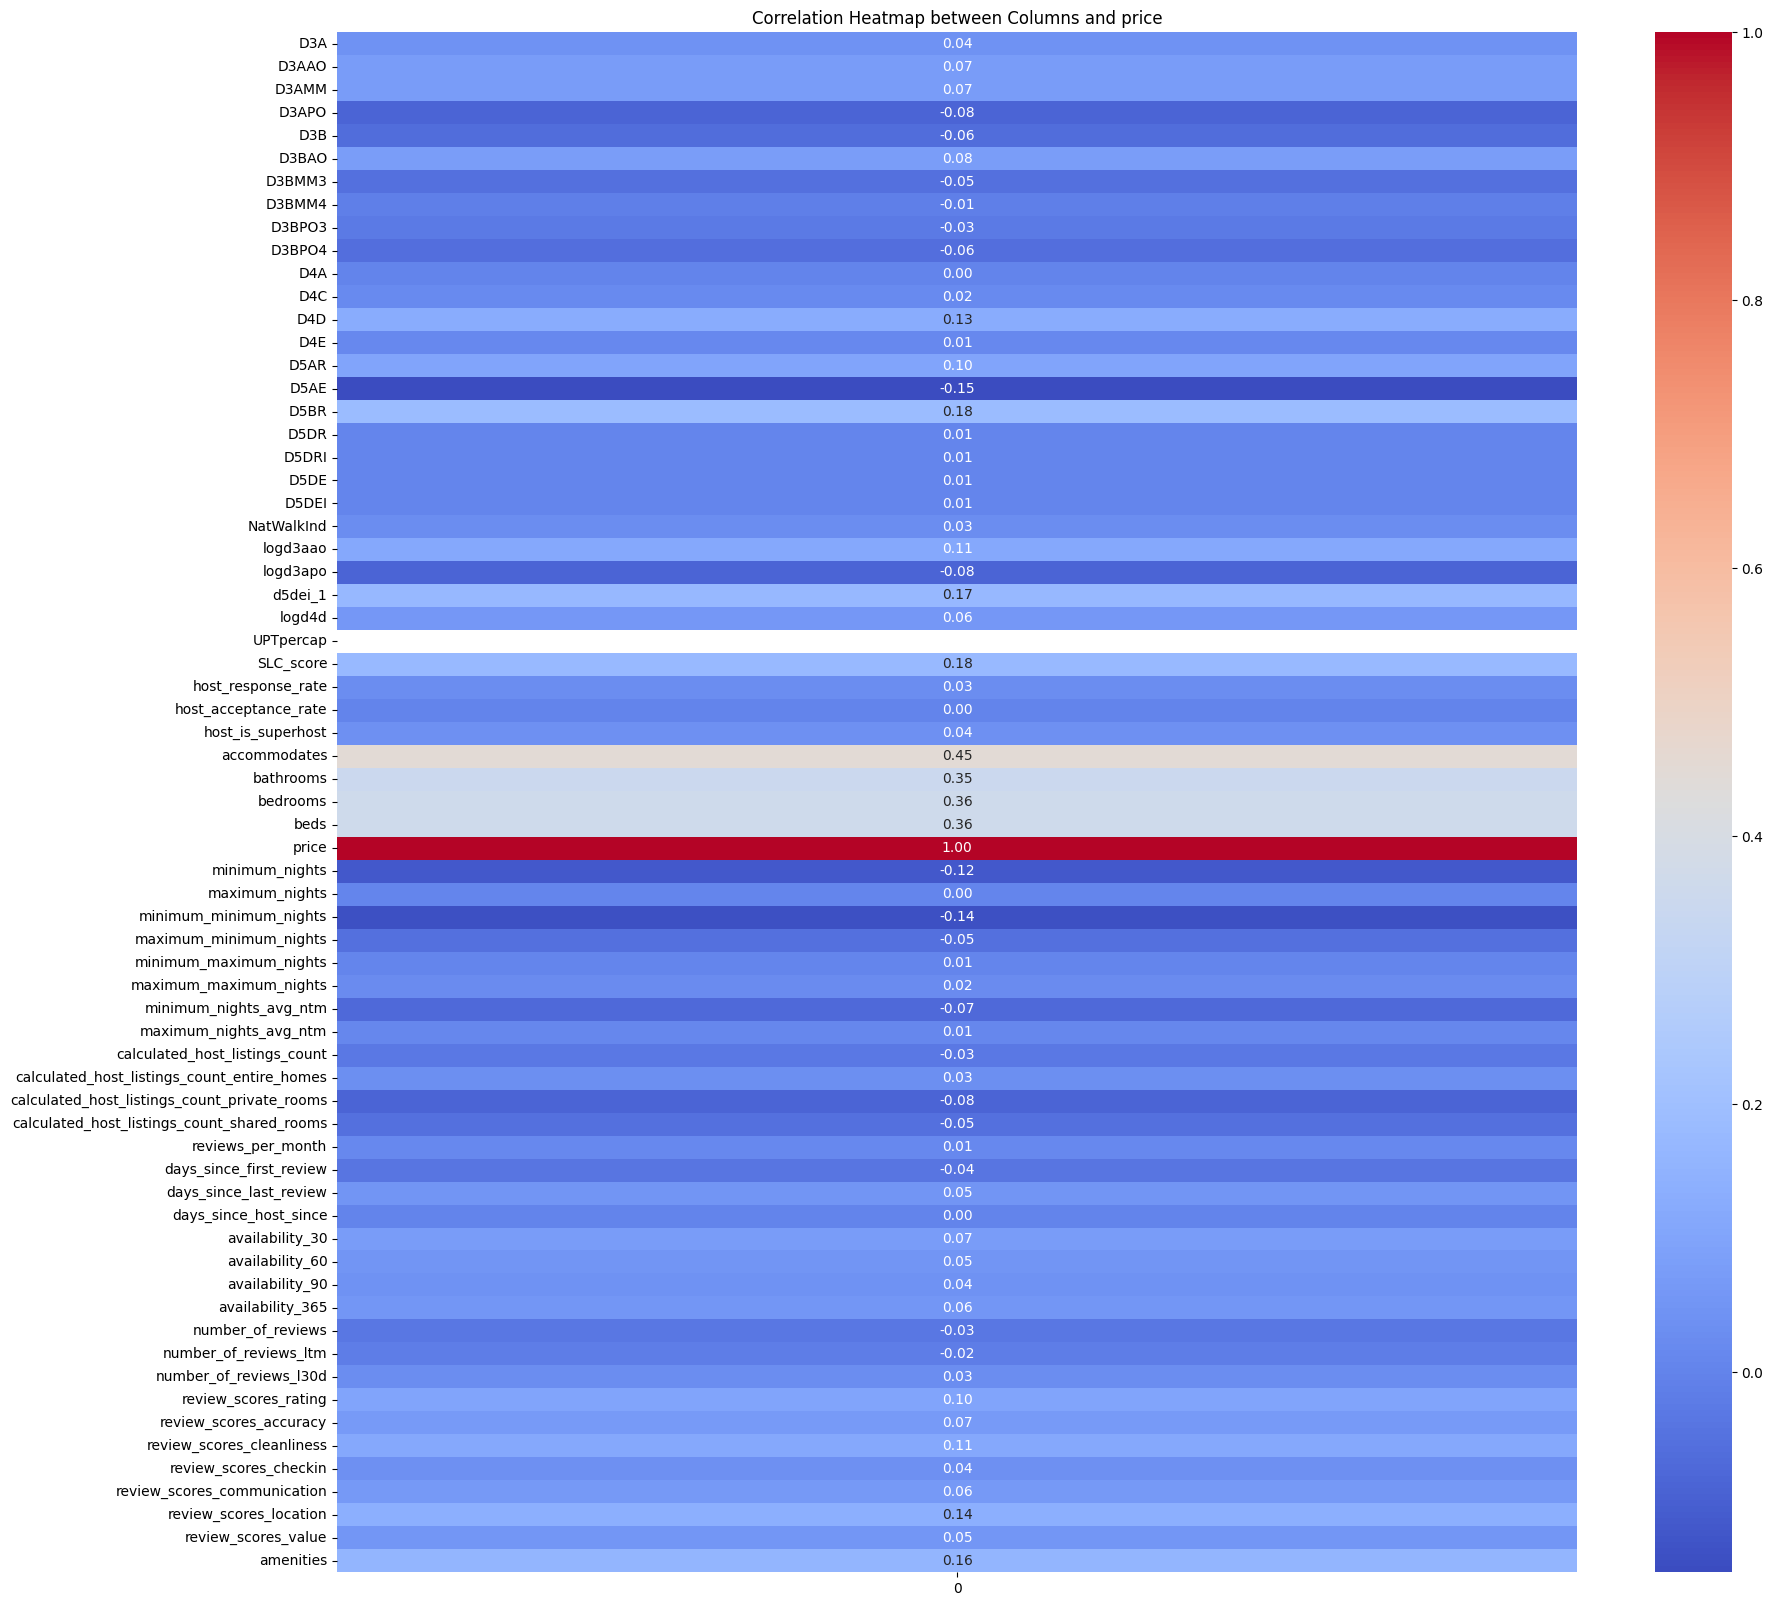

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix_price.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Columns and price')
plt.show()


In [ ]:
df.shape

(14184, 75)

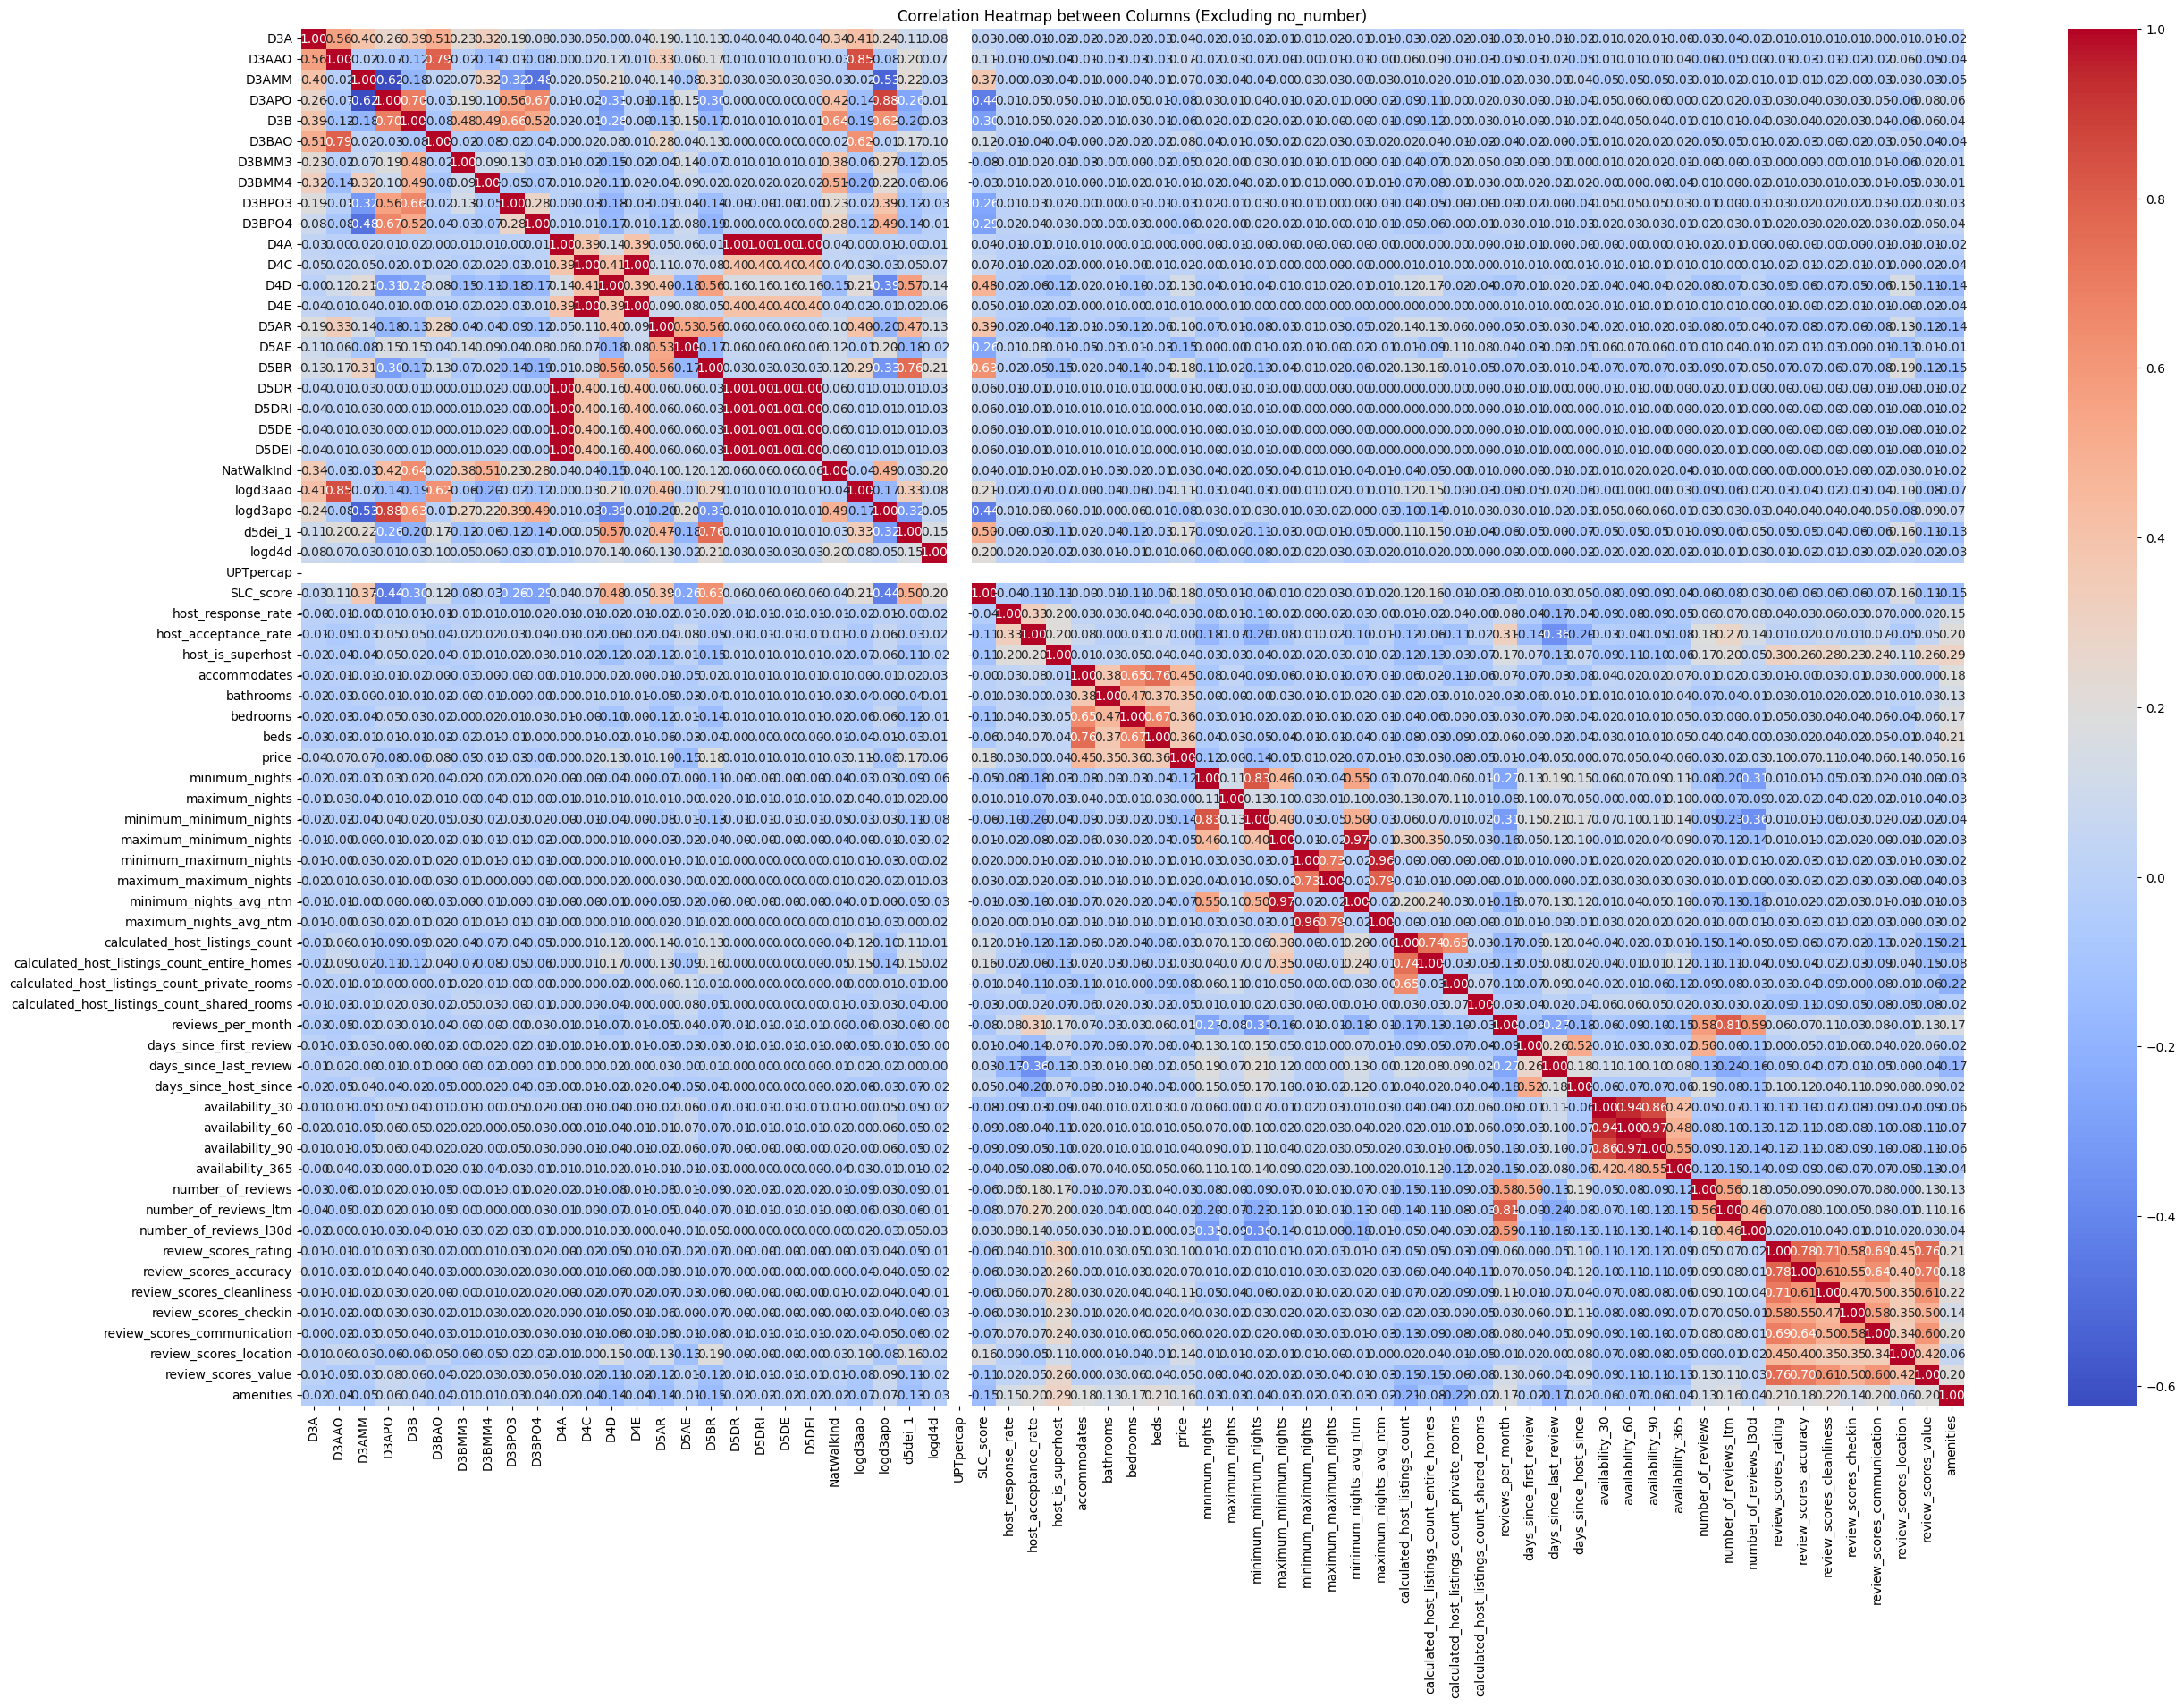

In [ ]:
# 共线性
correlation_matrix_all = selected_cols.corr()
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Columns (Excluding no_number)')
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
numeric_cols = df.select_dtypes(include=['int', 'float'])

# 删除缺失值
numeric_cols = numeric_cols.dropna()

# 计算 VIF
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_cols.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_cols.values, i) for i in range(numeric_cols.shape[1])]
vif_data

,feature,VIF
0,id,2.069602
1,D3A,0.919922
2,D3AAO,1.191393
3,D3AMM,1.060306
4,D3APO,1.114737
...,...,...
63,review_scores_checkin,0.112861
64,review_scores_communication,0.153417
65,review_scores_location,0.156321
66,review_scores_value,0.237152


In [ ]:
# 严重多重共线性
has_multiL_problem=vif_data[vif_data['VIF']>=10]
display(has_multiL_problem)

,feature,VIF
11,D4A,189.341902
12,D4C,1384.710642
14,D4E,1361.267716
18,D5DR,2993.407073
19,D5DRI,2993.429795
20,D5DE,2993.407063
21,D5DEI,2993.395506
41,minimum_maximum_nights,12.824294
44,maximum_nights_avg_ntm,16.157651


In [ ]:
high_vif_features = vif_data[vif_data['VIF'] >= 10]['feature'].tolist()

# 从 DataFrame 中删除 VIF 大于等于 10 的特征
df = df.drop(columns=high_vif_features)

从结果中，我们可以发现'D5DE', 'D5DEI', 'D5DR','D5DRI'完全相同，保留一个就可以；

'availability_60' 'availability_90'高度趋同，保留一个就可以；

有一个问题就是 'maximum_nights_avg_ntm', 'minimum_nights_avg_ntm'应该是高度相关的，因为代码都把他们提出来了，但热图里面看不出（但之后模型，估计会把相关变量减掉的）


## Encode Labels

In [ ]:
# 先看分布，决定编码的方式
# TURE, FLASE的用二进制编码（看变量是否存在）/标签编码（关注变量大小count的，随机森林）
#我们用标签

# 对于room_type和bathroom_text

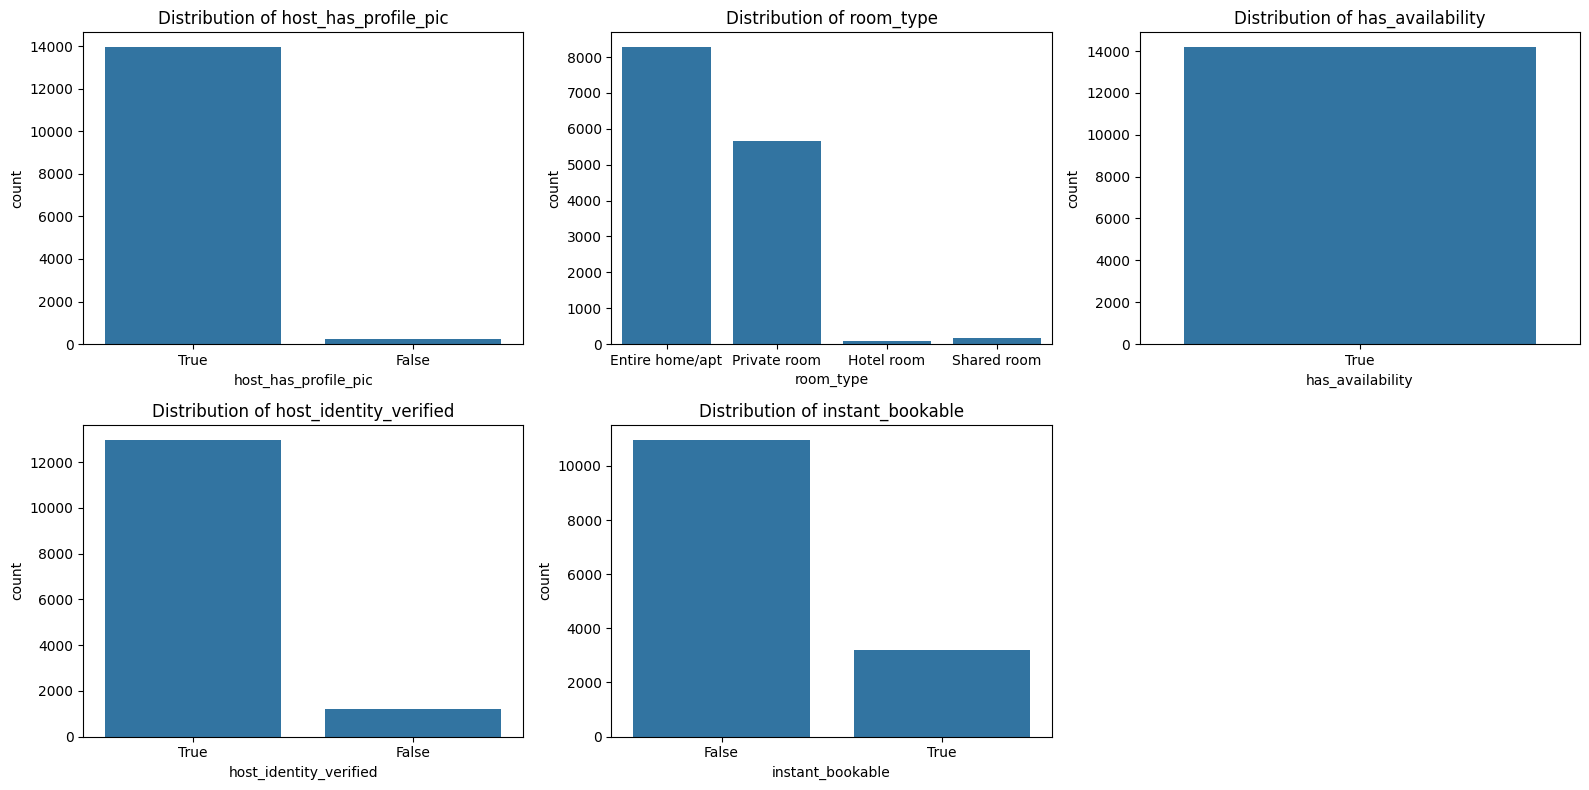

In [ ]:
# 设置图形大小
plt.figure(figsize=(16, 8))

# 绘制 host_has_profile_pic 的计数图
plt.subplot(2, 3, 1)
sns.countplot(data=df, x='host_has_profile_pic')
plt.title('Distribution of host_has_profile_pic')

# 绘制 room_type 的计数图
plt.subplot(2, 3, 2)
sns.countplot(data=df, x='room_type')
plt.title('Distribution of room_type')


# 绘制 has_availability 的计数图
plt.subplot(2, 3, 3)
sns.countplot(data=df, x='has_availability')
plt.title('Distribution of has_availability')

# 绘制 host_identity_verified 的计数图
plt.subplot(2, 3, 4)
sns.countplot(data=df, x='host_identity_verified')
plt.title('Distribution of host_identity_verified')

# 绘制 instant_bookable 的计数图
plt.subplot(2, 3, 5)
sns.countplot(data=df, x='instant_bookable')
plt.title('Distribution of instant_bookable')

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

In [ ]:
label_cols = ['host_has_profile_pic', 'has_availability', 'host_identity_verified', 'instant_bookable']

# 对每个标签列进行标签编码
for col in label_cols:
    label_encoder = LabelEncoder()
    df[col + '_encoded'] = label_encoder.fit_transform(df[col].astype(str))

# 删除原始的标签列
df = df.drop(columns=label_cols)
df.shape

(14184, 66)

In [ ]:
one_hot_cols = ['room_type']

one_hot_encoded = pd.get_dummies(df[one_hot_cols])

df = pd.concat([df, one_hot_encoded], axis=1)

df = df.drop(columns=one_hot_cols)

# EDA
### Actually, EDA is not an independent process, we've already conduct some EDA in the previous steps.
### Now, we will valusilize the data, and provide some views for the model building.

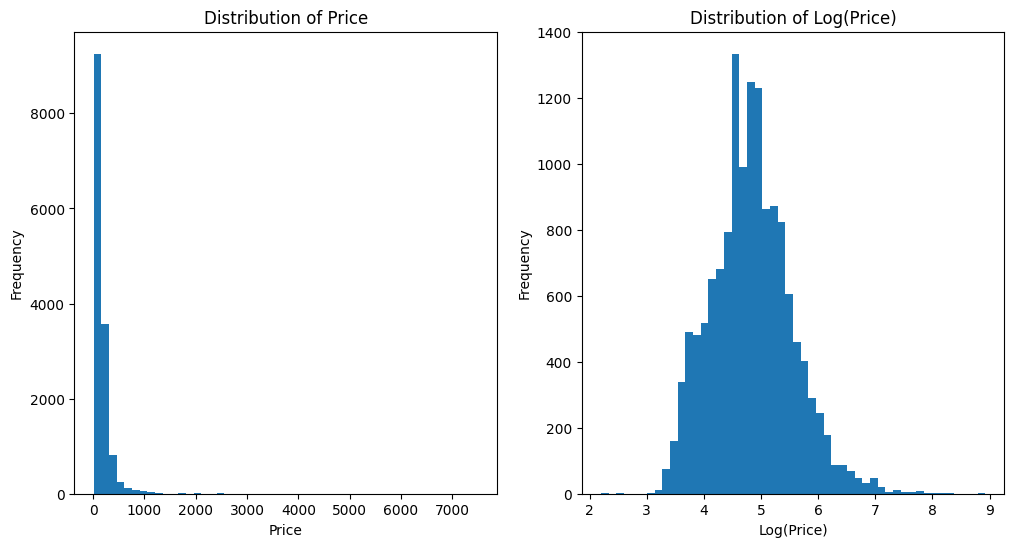

In [ ]:

plt.figure(figsize=(12, 6))

# 绘制原始价格直方图
plt.subplot(1, 2, 1)  # 子图1
plt.hist(df['price'], bins=50)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

# 对数转换后的价格直方图
plt.subplot(1, 2, 2)  # 子图2
log_price = np.log(df['price'])
plt.hist(log_price, bins=50)
plt.title('Distribution of Log(Price)')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

plt.show()

In [1]:
import requests

In [2]:
df.to_csv('df.csv', index=False)

NameError: name 'df' is not defined

In [ ]:
df.shape

(14184, 69)

# Feature selection

## Linear Regression

with data normalize and price log

In [5]:
df = pd.read_csv('df.csv')

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score



In [7]:
# 移除非数值列和对价格取对数
df_numeric = df.select_dtypes(include=[np.number])
df_numeric['log_price'] = np.log(df_numeric['price'])

# 分离特征和目标变量
X = df_numeric.drop(['price', 'log_price'], axis=1)
y = df_numeric['log_price']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 转换回 DataFrame，保持特征名称，并重新设置索引以匹配 y_train 和 y_test
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=y_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=y_test.index)

# 使用 statsmodels 进行特征选择
X_train_scaled = sm.add_constant(X_train_scaled)  # 添加常数项
X_test_scaled = sm.add_constant(X_test_scaled)  # 对测试数据也执行相同操作

model = sm.OLS(y_train, X_train_scaled)
results = model.fit()
print(results.summary())

# 根据 p 值选择显著特征
significant_features = [feature for feature, p_val in results.pvalues.items() if p_val < 0.05 and feature != 'const']
print("Significant features:", significant_features)

# 只使用显著的特征进行训练和测试
X_train_sig = X_train_scaled[significant_features + ['const']]  # 包含常数项
X_test_sig = X_test_scaled[significant_features + ['const']]

# 训练新的线性回归模型
model_sig = sm.OLS(y_train, X_train_sig)
results_sig = model_sig.fit()

# 预测和评估
y_pred = results_sig.predict(X_test_sig)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Final Model RMSE on Test Set:", test_rmse)
print("Final Model R² on Test Set:", test_r2)


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     249.8
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        07:14:06   Log-Likelihood:                -7369.1
No. Observations:               11347   AIC:                         1.486e+04
Df Residuals:                   11288   BIC:                         1.529e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

## Decision Tree

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

Selected features from Decision Tree: ['accommodates', 'calculated_host_listings_count_private_rooms', 'bathrooms', 'maximum_minimum_nights', 'SLC_score', 'bedrooms', 'D5BR', 'calculated_host_listings_count_entire_homes', 'minimum_nights_avg_ntm', 'amenities', 'availability_30', 'D5AE', 'days_since_last_review', 'availability_365', 'reviews_per_month', 'days_since_host_since', 'review_scores_rating', 'D5AR', 'review_scores_location', 'host_acceptance_rate', 'D4D']


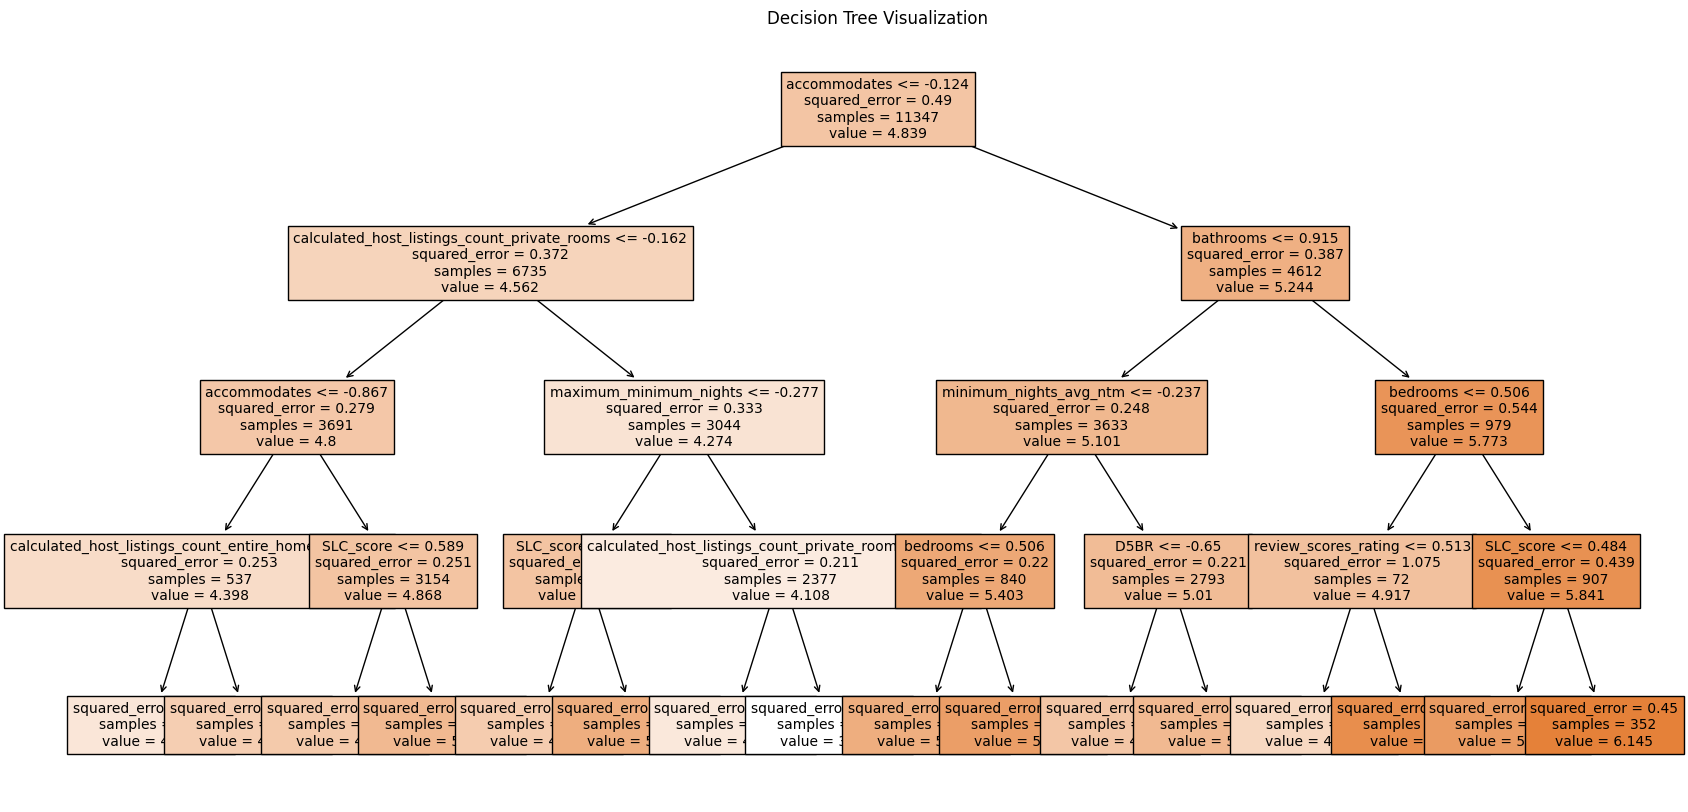

In [14]:
# 训练决策树模型
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)

# 获取特征重要性
dt_importances = pd.Series(dt.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# 选择重要性大于某个阈值的特征
threshold = 0.01  # 可以调整阈值
selected_features_dt = dt_importances[dt_importances > threshold].index.tolist()

print("Selected features from Decision Tree:", selected_features_dt)

# 训练决策树模型（限制深度以便可视化）
dt = DecisionTreeRegressor(max_depth=4, random_state=42)
dt.fit(X_train_scaled[selected_features_dt], y_train)

# 绘制决策树
plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=selected_features_dt, fontsize=10)
plt.title('Decision Tree Visualization')
plt.show()

In [ ]:
# # 定义参数网格
# 需要保留，这是后面为什么选择参数的原因，保留用以之后再次确认
# param_grid = {
#     'ccp_alpha': [0, 0.0001, 0.001, 0.01],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 10, 20],
#     'min_samples_leaf': [1, 5, 10]
# }

# # 进行网格搜索，这里要使用标准化后的训练数据
# grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='r2')
# grid_search.fit(X_train_scaled, y_train)
# print(f"Best parameters: {grid_search.best_params_}")

In [15]:
# 使用网格搜索得到的最佳参数重新训练决策树模型
dt_optimized = DecisionTreeRegressor(
    ccp_alpha=0.0001,
    max_depth=10,
    min_samples_leaf=10,
    min_samples_split=2,
    random_state=42
)
dt_optimized.fit(X_train_scaled, y_train)

# 预测训练集和测试集
y_pred_train_opt = dt_optimized.predict(X_train_scaled)
y_pred_test_opt = dt_optimized.predict(X_test_scaled)

# 计算 RMSE 和 R²
train_rmse_opt = mean_squared_error(y_train, y_pred_train_opt, squared=False)
test_rmse_opt = mean_squared_error(y_test, y_pred_test_opt, squared=False)
train_r2_opt = r2_score(y_train, y_pred_train_opt)
test_r2_opt = r2_score(y_test, y_pred_test_opt)

print(f"Optimized Decision Tree Training RMSE: {train_rmse_opt:.2f}")
print(f"Optimized Decision Tree Test RMSE: {test_rmse_opt:.2f}")
print(f"Optimized Decision Tree Training R²: {train_r2_opt:.3f}")
print(f"Optimized Decision Tree Test R²: {test_r2_opt:.3f}")

Optimized Decision Tree Training RMSE: 0.35
Optimized Decision Tree Test RMSE: 0.44
Optimized Decision Tree Training R²: 0.747
Optimized Decision Tree Test R²: 0.618


In [16]:
# 使用决策树选出的特征训练随机森林
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled[selected_features_dt], y_train)

# 预测
y_pred_train_rf = rf.predict(X_train_scaled[selected_features_dt])
y_pred_test_rf = rf.predict(X_test_scaled[selected_features_dt])

# 计算性能指标
train_rmse_rf = mean_squared_error(y_train, y_pred_train_rf, squared=False)
test_rmse_rf = mean_squared_error(y_test, y_pred_test_rf, squared=False)
train_r2_rf = r2_score(y_train, y_pred_train_rf)
test_r2_rf = r2_score(y_test, y_pred_test_rf)

print(f"Random Forest Training RMSE: {train_rmse_rf:.2f}")
print(f"Random Forest Test RMSE: {test_rmse_rf:.2f}")
print(f"Random Forest Training R²: {train_r2_rf:.3f}")
print(f"Random Forest Test R²: {test_r2_rf:.3f}")

Random Forest Training RMSE: 0.13
Random Forest Test RMSE: 0.36
Random Forest Training R²: 0.964
Random Forest Test R²: 0.750


## Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [18]:
# 使用决策树选出的特征训练随机森林
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled[selected_features_dt], y_train)

# 获取特征重要性
rf_importances = pd.Series(rf.feature_importances_, index=selected_features_dt).sort_values(ascending=False)

# 再次选择重要性高的特征
selected_features_rf = rf_importances[rf_importances > threshold].index.tolist()
print("Selected features from Random Forest:", selected_features_rf)

Selected features from Random Forest: ['accommodates', 'calculated_host_listings_count_private_rooms', 'bathrooms', 'SLC_score', 'maximum_minimum_nights', 'minimum_nights_avg_ntm', 'D5BR', 'amenities', 'calculated_host_listings_count_entire_homes', 'bedrooms', 'reviews_per_month', 'D5AE', 'days_since_last_review', 'availability_30', 'days_since_host_since', 'availability_365', 'D5AR', 'review_scores_rating', 'D4D', 'review_scores_location', 'host_acceptance_rate']


In [19]:
# # 使用OOB得分确定最佳的max_features参数
# # 可以跑或不跑，后面直接使用了结果作为参数，可以跳过，但保留，已注释掉
# oob_scores = []
# max_features_options = [0.4 + i/20 for i in range(5)]

# for max_ft in tqdm(max_features_options):
#     rf = RandomForestRegressor(n_estimators=100, max_features=max_ft, oob_score=True, random_state=42)
#     rf.fit(X_train_scaled, y_train)
#     oob_scores.append(rf.oob_score_)

# # 绘制OOB分数图
# plt.figure(figsize=(10, 6))
# plt.plot(max_features_options, oob_scores, marker='o')
# plt.xlabel("% of features")
# plt.ylabel("OOB R²")
# plt.title("OOB R² by max features percentage")
# plt.grid(True)
# plt.show()

In [20]:
# 使用最佳的max_features比例训练随机森林
optimal_max_features = 0.45
rf_optimal = RandomForestRegressor(n_estimators=150, max_depth=10, max_features=optimal_max_features, random_state=42, oob_score=True)
rf_optimal.fit(X_train_scaled[selected_features_rf], y_train)

# 预测
y_pred_train_optimal = rf_optimal.predict(X_train_scaled[selected_features_rf])
y_pred_test_optimal = rf_optimal.predict(X_test_scaled[selected_features_rf])

# 计算性能指标
train_rmse_optimal = mean_squared_error(y_train, y_pred_train_optimal, squared=False)
test_rmse_optimal = mean_squared_error(y_test, y_pred_test_optimal, squared=False)
train_r2_optimal = r2_score(y_train, y_pred_train_optimal)
test_r2_optimal = r2_score(y_test, y_pred_test_optimal)

print(f"Optimized Random Forest Training RMSE: {train_rmse_optimal:.2f}")
print(f"Optimized Random Forest Test RMSE: {test_rmse_optimal:.2f}")
print(f"Optimized Random Forest Training R²: {train_r2_optimal:.3f}")
print(f"Optimized Random Forest Test R²: {test_r2_optimal:.3f}")


Optimized Random Forest Training RMSE: 0.29
Optimized Random Forest Test RMSE: 0.37
Optimized Random Forest Training R²: 0.825
Optimized Random Forest Test R²: 0.726


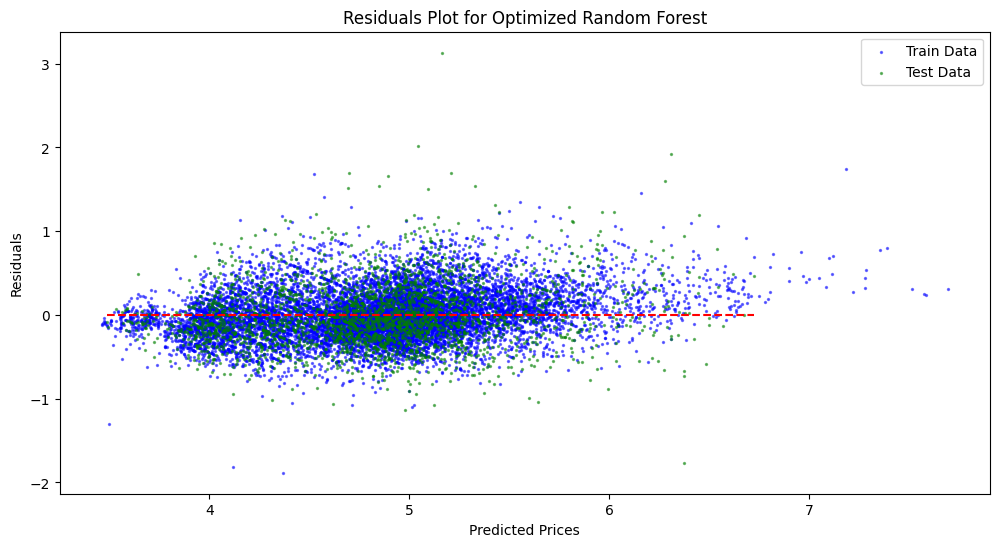

In [21]:
# 计算残差
residuals_train_optimal = y_train - y_pred_train_optimal
residuals_test_optimal = y_test - y_pred_test_optimal

# 绘制残差图
plt.figure(figsize=(12, 6))
plt.scatter(y_pred_train_optimal, residuals_train_optimal, color='blue', s=2, alpha=0.5, label='Train Data')
plt.scatter(y_pred_test_optimal, residuals_test_optimal, color='green', s=2, alpha=0.5, label='Test Data')
plt.hlines(y=0, xmin=min(y_pred_test_optimal), xmax=max(y_pred_test_optimal), color='red', linestyles='dashed')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Optimized Random Forest')
plt.legend()
plt.show()